_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Name: FILL IN YOUR NAMES HERE

# Coding Lab 4

If needed, download the data files ```nds_cl_4_*.csv``` from ILIAS and save it in the subfolder ```../data/```. Use a subset of the data for testing and debugging, ideally focus on a single cell (e.g. cell number x). The spike times and stimulus conditions are read in as pandas data frames. You can solve the exercise by making heavy use of that, allowing for many quite compact computationis. If you need help on that, there is lots of [documentation](http://pandas.pydata.org/pandas-docs/stable/index.html) and several good [tutorials](https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python#gs.L37i87A) are available online. Of course, converting the data into classical numpy arrays is also valid.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.optimize as opt

from scipy import signal as signal
from typing import Tuple

import itertools

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2024-06-03 15:46:29Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

sklearn: 1.4.2

numpy     : 1.26.4
seaborn   : 0.13.2
scipy     : 1.13.0
pandas    : 2.2.2
matplotlib: 3.9.0

Watermark: 2.4.3



In [2]:
# plt.style.use("../matplotlib_style.txt")

## Load data

In [3]:
spikes = pd.read_csv("data/nds_cl_4_spiketimes.csv")  # neuron id, spike time
stims = pd.read_csv("data/nds_cl_4_stimulus.csv")  # stimulus onset in ms, direction

stimDur = 2000.0  # in ms
nTrials = 11  # number of trials per condition
nDirs = 16  # number of conditions
deltaDir = 22.5  # difference between conditions

stims["StimOffset"] = stims["StimOnset"] + stimDur

We require some more information about the spikes for the plots and analyses we intend to make later. With a solution based on dataframes, it is natural to compute this information here and add it as additional columns to the `spikes` dataframe by combining it with the `stims` dataframe. We later need to know which condition (`Dir`) and trial (`Trial`) a spike was recorded in, the relative spike times compared to stimulus onset of the stimulus it was recorded in (`relTime`) and whether a spike was during the stimulation period (`stimPeriod`). But there are many options how to solve this exercise and you are free to choose any of them.

In [4]:
# you may add computations as specified above
spikes["Dir"] = np.nan
spikes["relTime"] = np.nan
spikes["Trial"] = np.nan
spikes["stimPeriod"] = np.nan

dirs = np.unique(stims["Dir"])
trialcounter = np.zeros_like(dirs)

for i, row in stims.iterrows():
    trialcounter[dirs == row["Dir"]] += 1

    i0 = spikes["SpikeTimes"] > row["StimOnset"]
    i1 = spikes["SpikeTimes"] < row["StimOffset"]

    select = i0.values & i1.values

    spikes.loc[select, "Dir"] = row["Dir"]
    spikes.loc[select, "Trial"] = trialcounter[dirs == row["Dir"]][0]
    spikes.loc[select, "relTime"] = spikes.loc[select, "SpikeTimes"] - row["StimOnset"]
    spikes.loc[select, "stimPeriod"] = True

spikes = spikes.dropna()

C:\Users\nekur\AppData\Local\Temp\ipykernel_10460\4012369867.py:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  spikes.loc[select, "stimPeriod"] = True


In [5]:
spikes.head()

,Neuron,SpikeTimes,Dir,relTime,Trial,stimPeriod
514,1,15739.000000,270.0,169.000000,1.0,True
515,1,15776.566667,270.0,206.566667,1.0,True
516,1,15808.466667,270.0,238.466667,1.0,True
517,1,15821.900000,270.0,251.900000,1.0,True
518,1,15842.966667,270.0,272.966667,1.0,True


In [6]:
spikes.to_csv("spikes_df.csv")

## Task 1: Plot spike rasters

In a raster plot, each spike is shown by a small tick at the time it occurs relative to stimulus onset. Implement a function `plotRaster()` that plots the spikes of one cell as one trial per row, sorted by conditions (similar to what you saw in the lecture). Why are there no spikes in some conditions and many in others?

If you opt for a solution without a dataframe, you need to change the interface of the function.

*Grading: 2 pts*


In [7]:
def plotRaster(spikes: pd.DataFrame, neuron: int):
    """Plot spike rasters for a single neuron sorted by condition.

    Parameters
    ----------
    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod
    neuron: int
        Neuron ID

    Note
    ----
    This function does not return anything, it just creates a plot!
    """
    fig, ax = plt.subplots(figsize=(8, 4))

    # Filter df for the specified neuron
    neuron_data = spikes[spikes["Neuron"] == neuron]

    # All stimulus conditions (directions) sorted
    conditions = sorted(neuron_data["Dir"].unique())

    # Plot spikes for each condition
    for i, condition in enumerate(conditions):
        condition_data = neuron_data[neuron_data["Dir"] == condition]
        trials = sorted(condition_data["Trial"].unique())

        for j, trial in enumerate(trials):
            trial_data = condition_data[condition_data["Trial"] == trial]
            spike_times = trial_data["relTime"]

            # Plot spikes
            ax.plot(
                spike_times, [i] * len(spike_times), "|", color="black", markersize=10
            )

    # Label the axes
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Stimulus Direction (degrees)")
    ax.set_title(f"Raster Plot Neuron {neuron}")

    # Set y-ticks to show condition labels
    ax.set_yticks(range(len(conditions)))
    ax.set_yticklabels(conditions)

    plt.show()

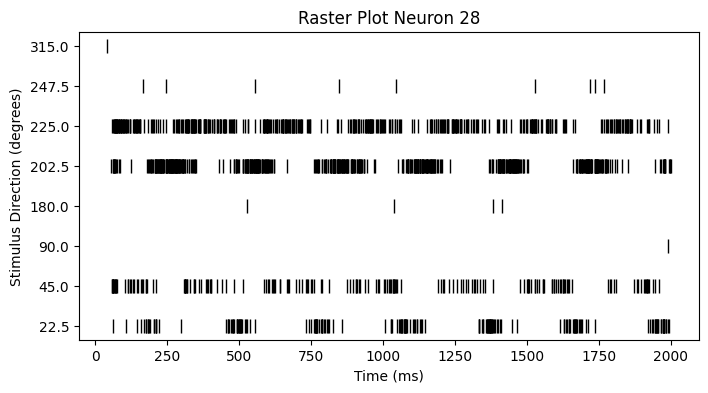

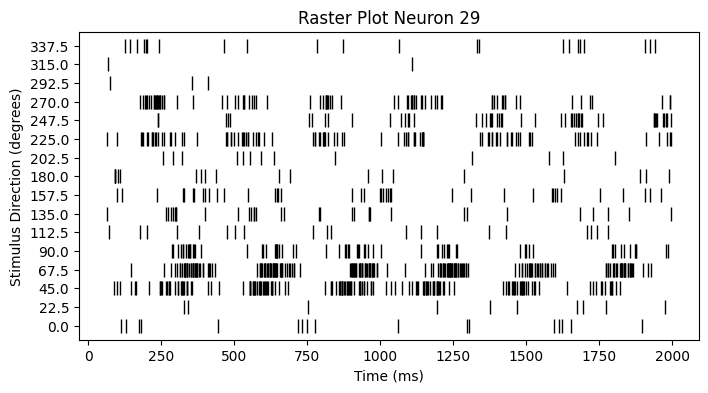

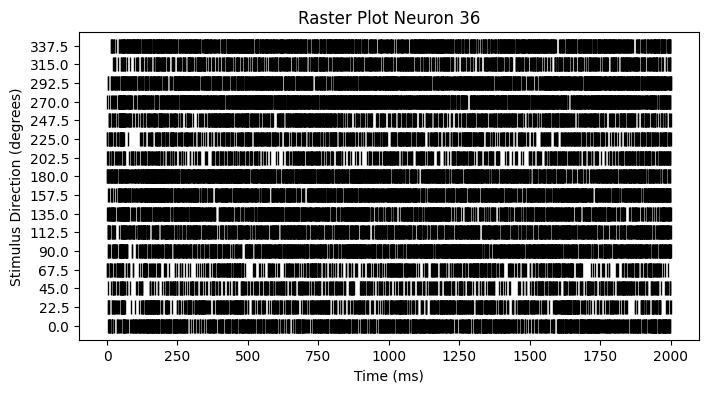

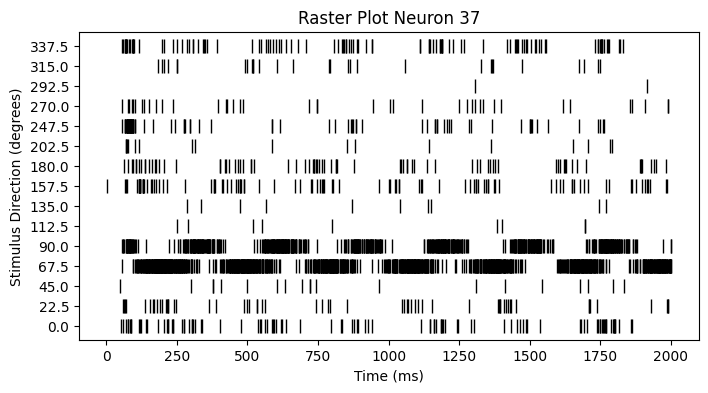

In [8]:
plotRaster(spikes, 28)
plotRaster(spikes, 29)
plotRaster(spikes, 36)
plotRaster(spikes, 37)

In [9]:
def plotRaster2(spikes: pd.DataFrame, neuron: int):
    """Plot spike rasters for a single neuron sorted by condition.

    Parameters
    ----------
    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod
    neuron: int
        Neuron ID

    Note
    ----
    This function does not return anything, it just creates a plot!
    """
    fig, ax = plt.subplots(figsize=(8, 4))

    # Filter df for the specified neuron
    neuron_data = spikes[spikes["Neuron"] == neuron]

    # All stimulus conditions (directions) sorted
    conditions = sorted(neuron_data["Dir"].unique())

    # Plot spikes for each condition
    for condition in conditions:
        condition_data = neuron_data[neuron_data["Dir"] == condition]
        trials = sorted(condition_data["Trial"].unique())

        for trial in trials:
            trial_data = condition_data[condition_data["Trial"] == trial]
            spike_times = trial_data["relTime"]

            # Plot spikes
            ax.plot(
                spike_times,
                [condition] * len(spike_times),
                "|",
                color="black",
                markersize=7,
            )

    # Axes
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Stimulus Direction (degrees)")
    ax.set_title(f"Raster Plot Neuron {neuron}")
    ax.set_ylim(-10, 360)
    ax.set_yticks(np.arange(0, 360, 22.5))

    plt.show()

Show examples of different neurons. Good candidates to check are 28, 29, 36 or 37. 

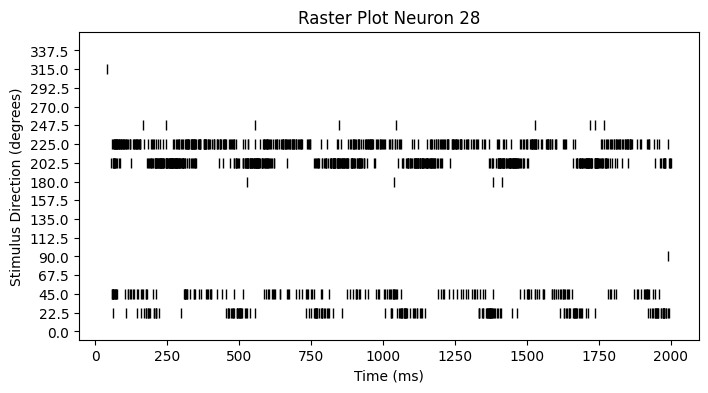

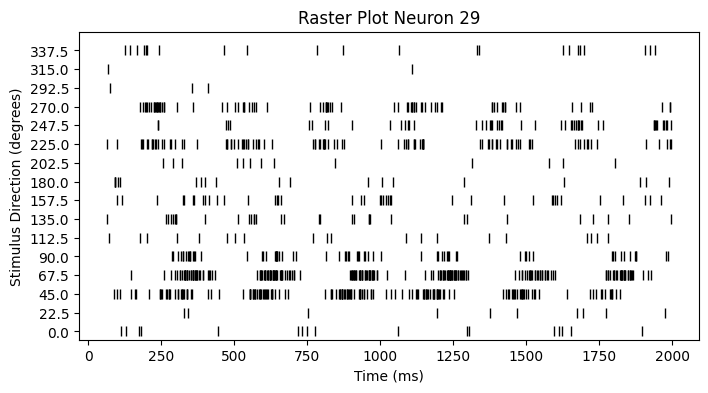

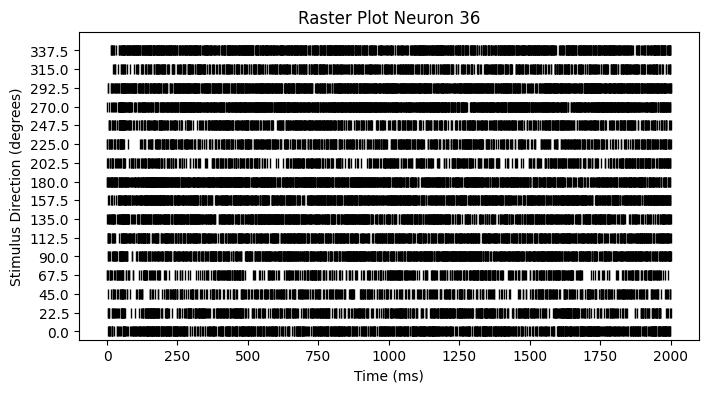

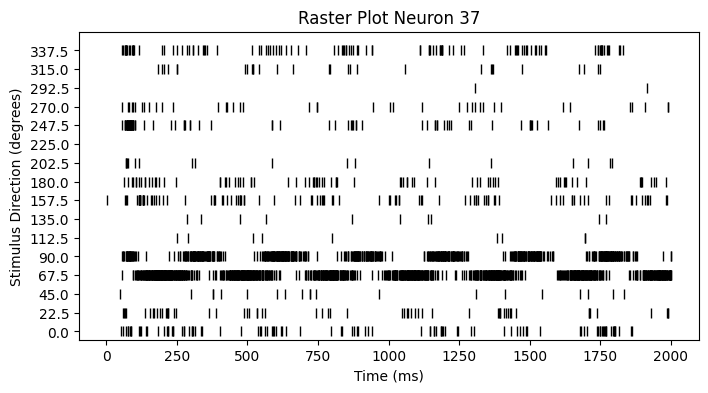

In [10]:
plotRaster2(spikes, 28)
plotRaster2(spikes, 29)
plotRaster2(spikes, 36)
plotRaster2(spikes, 37)

## Task 2: Plot spike density functions

Compute an estimate of the spike rate against time relative to stimulus onset. There are two ways:
* Discretize time: Decide on a bin size, count the spikes in each bin and average across trials. 
* Directly estimate the probability of spiking using a density estimator with specified kernel width. 

Implement one of them in the function `plotPsth()`. If you use a dataframe you may need to change the interface of the function.


*Grading: 2 pts*


In [11]:
def plotPSTH(spikes: pd.DataFrame, neuron: int):
    """Plot PSTH for a single neuron sorted by condition

    Parameters
    ----------

    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod

    neuron: int
        Neuron ID


    Note
    ----

    this function does not return anything, it just creates a plot!
    """

    # insert your code here

    fig, ax = plt.subplots(figsize=(8, 4))

    # ------------------------------------------------
    # Implement one of the spike rate estimates (1 pt)
    # ------------------------------------------------

    # ---------------------------------------------
    # Plot the obtained spike rate estimates (1 pt)
    # ---------------------------------------------

    # plot should look similar to `plotRaster`
    # you can plot use plt.hist for each direction, but much cleaner
    # is to only plot bin centers vs bin heights using plt.plot

In [12]:
def plotPSTH(spikes: pd.DataFrame, neuron: int, bin_size_ms: float):
    """Plot PSTH for a single neuron sorted by condition

    Parameters
    ----------
    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod
    neuron: int
        Neuron ID
    bin_size_ms: float
        Size of each time bin in milliseconds

    Note
    ----
    This function does not return anything, it just creates a plot!
    """

    # Filter data for the specified neuron
    neuron_data = spikes[spikes["Neuron"] == neuron]

    # Get unique conditions (directions)
    conditions = sorted(neuron_data["Dir"].unique())

    # Define bins
    num_bins = int(np.ceil(stimDur / bin_size_ms))
    bins = np.linspace(0, stimDur, num_bins + 1)

    # Initialize spike rate estimates
    spike_rates = np.zeros((len(conditions), num_bins))

    # Compute spike rate estimates for each condition
    for i, condition in enumerate(conditions):
        condition_data = neuron_data[neuron_data["Dir"] == condition]
        trials = sorted(condition_data["Trial"].unique())

        # Count spikes in each bin and average across trials
        for trial in trials:
            trial_data = condition_data[condition_data["Trial"] == trial]
            spike_times = trial_data["relTime"]

            # Compute spike counts in each bin
            spike_counts, _ = np.histogram(spike_times, bins=bins)

            # Update spike rate estimate for the current condition
            spike_rates[i] += spike_counts

        # Average spike rates across trials
        spike_rates[i] /= len(trials)

    # Plot PSTH
    fig, ax = plt.subplots(figsize=(8, 4))

    for i, condition in enumerate(conditions):
        ax.plot(
            bins[:-1] + bin_size_ms / 2, spike_rates[i], label=f"Condition {condition}"
        )

    # Label the axes
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Spike Rate (spikes/bin)")
    ax.set_title(f"PSTH for Neuron {neuron}")
    ax.legend()
    plt.show()


# Example usage:
# Assuming spikes_df is your DataFrame, neuron_id is the ID of the neuron you are interested in,
# and bin_size_ms is the desired bin size in milliseconds.
# plotPSTH(spikes_df, neuron_id, bin_size_ms)

In [13]:
def plotPSTH(spikes: pd.DataFrame, neuron: int, bin_size_ms: float):
    """Plot PSTH for a single neuron sorted by condition

    Parameters
    ----------
    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod
    neuron: int
        Neuron ID
    bin_size_ms: float
        Size of each time bin in milliseconds

    Note
    ----
    This function does not return anything, it just creates a plot!
    """

    # Filter data for the specified neuron
    neuron_data = spikes[spikes["Neuron"] == neuron]

    # Get unique conditions (directions)
    conditions = sorted(neuron_data["Dir"].unique())

    # Define bins
    max_rel_time = neuron_data["relTime"].max()
    num_bins = int(np.ceil(max_rel_time / bin_size_ms))
    bins = np.linspace(0, max_rel_time, num_bins + 1)

    # Initialize spike rate estimates
    spike_rates = np.zeros((len(conditions), num_bins))

    # Compute spike rate estimates for each condition
    for i, condition in enumerate(conditions):
        condition_data = neuron_data[neuron_data["Dir"] == condition]
        trials = sorted(condition_data["Trial"].unique())

        # Count spikes in each bin and average across trials
        for trial in trials:
            trial_data = condition_data[condition_data["Trial"] == trial]
            spike_times = trial_data["relTime"]

            # Compute spike counts in each bin
            spike_counts, _ = np.histogram(spike_times, bins=bins)

            # Update spike rate estimate for the current condition
            spike_rates[i] += spike_counts

        # Average spike rates across trials
        spike_rates[i] /= len(trials)

    # Compute bin centers
    bin_centers = bins[:-1] + bin_size_ms / 2

    # Plot PSTH
    fig, ax = plt.subplots(figsize=(8, 4))

    for i, condition in enumerate(conditions):
        ax.plot(bin_centers, spike_rates[i], label=f"Condition {condition}")

    # Label the axes
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Spike Rate (spikes/bin)")
    ax.set_title(f"PSTH for Neuron {neuron}")
    ax.legend()
    plt.show()

Show examples of different neurons. Good candidates to check are 28, 29, 36 or 37. 

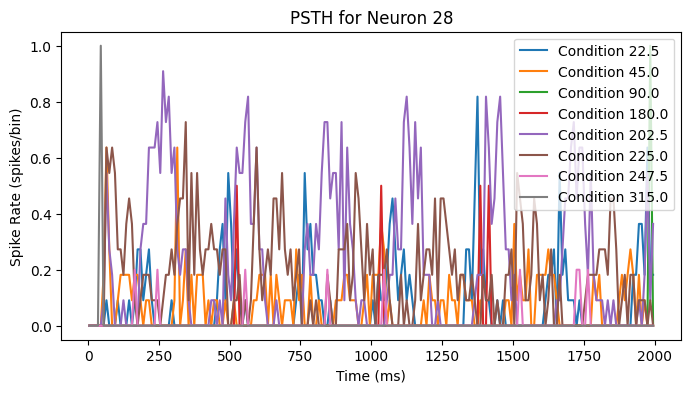

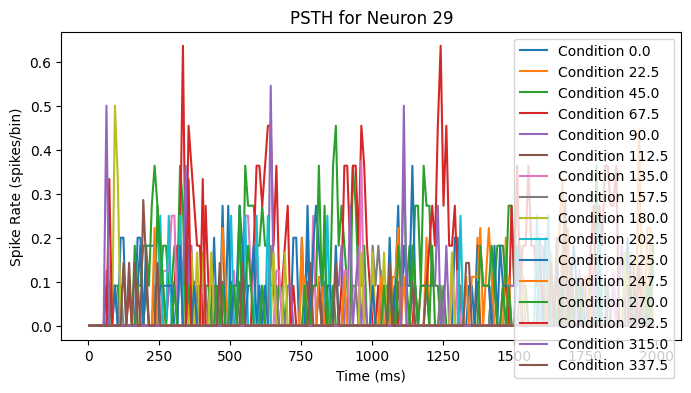

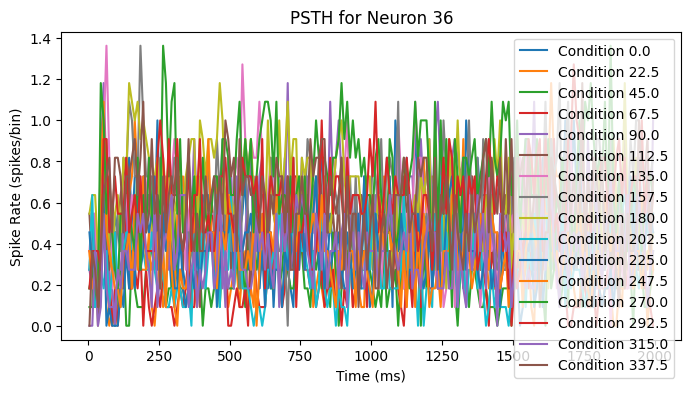

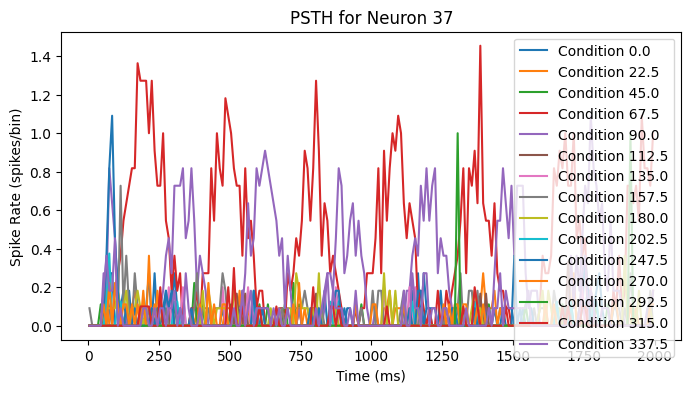

In [14]:
plotPSTH(spikes, 28, 10)
plotPSTH(spikes, 29, 10)
plotPSTH(spikes, 36, 10)
plotPSTH(spikes, 37, 10)

In [15]:
# plotRaster(spikes, 37)
# plotPSTH(spikes, 37)

## Task 3: Fit and plot tuning functions

The goal is to visualize the activity of each neuron as a function of stimulus direction. First, compute the spike counts of each neuron for each direction of motion and trial.  The result should be a matrix `x`, where $x_{jk}$ represents the spike count of the $j$-th response to the $k$-th direction of motion (i.e. each column contains the spike counts for all trials with one direction of motion).	If you used dataframes above, the `groupby()` function allows to implement this very compactely. Make sure you don't loose trials with zero spikes though. Again, other implementations are completely fine.

Fit the tuning curve, i.e. the average spike count per direction, using a von Mises model. To capture the non-linearity and direction selectivity of the neurons, we will fit a modified von Mises function:

$$ f(\theta) = \exp(\alpha + \kappa (\cos (2*(\theta-\phi))-1) + \nu (\cos (\theta-\phi)-1))$$

Here, $\theta$ is the stimulus direction. Implement the von Mises function in `vonMises()` and plot it to understand how to interpret its parameters $\phi$, $\kappa$, $\nu$, $\alpha$. Perform a non-linear least squares fit using a package/function of your choice. Implement the fitting in `tuningCurve()`. 

Plot the average number of spikes per direction, the spike counts from individual trials as well as your optimal fit.

Select two cells that show nice tuning to test you code.

*Grading: 3 pts*

In [16]:
def vonMises(θ: np.ndarray, α: float, κ: float, ν: float, ϕ: float) -> np.ndarray:
    """Evaluate the parametric von Mises tuning curve with parameters p at locations theta.

    Parameters
    ----------

    θ: np.array, shape=(N, )
        Locations. The input unit is degree.

    α, κ, ν, ϕ : float
        Function parameters

    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    """

    # insert your code here

    # -----------------------------------
    # Implement the Mises model (0.5 pts)
    # -----------------------------------

    f = np.exp(
        α
        + κ * (np.cos(2 * (np.deg2rad(θ) - np.deg2rad(ϕ))) - 1)
        + ν * (np.cos(np.deg2rad(θ) - np.deg2rad(ϕ)) - 1)
    )
    return f

Plot the von Mises function while varying the parameters systematically.

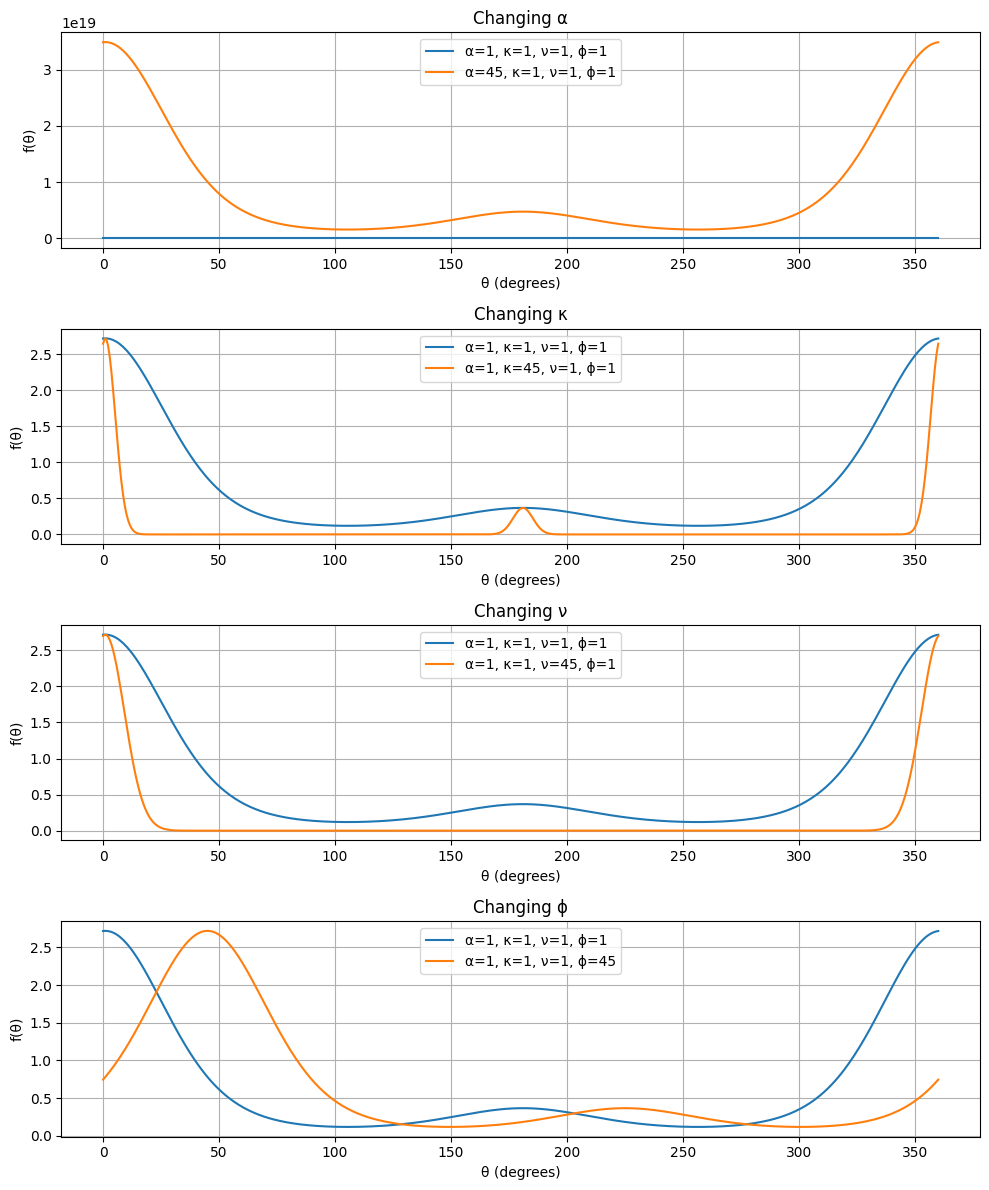

In [17]:
# --------------------------------------------------------------------------------
# plot von Mises curves with varying parameters and explain what they do (0.5 pts)
# --------------------------------------------------------------------------------

θ = np.linspace(0, 360, 500)
fig, ax = plt.subplots(4, 1, figsize=(10, 12))

# parameter
parameters_ground = {"α": 1, "κ": 1, "ν": 1, "ϕ": 1}

for i, param_key in enumerate(parameters_ground.keys()):
    parameters_change = parameters_ground.copy()
    parameters_change[param_key] = 45
    parameters_all = [parameters_ground, parameters_change]

    # Plot tuning curves for different parameters
    for param in parameters_all:
        f = vonMises(θ, param["α"], param["κ"], param["ν"], param["ϕ"])
        ax[i].plot(
            θ,
            f,
            label=f"α={param['α']}, κ={param['κ']}, ν={param['ν']}, ϕ={param['ϕ']}",
        )

    # Add labels and legend
    ax[i].set_xlabel("θ (degrees)")
    ax[i].set_ylabel("f(θ)")
    ax[i].set_title(f"Changing {param_key}")
    ax[i].legend()
    ax[i].grid(True)

plt.tight_layout()
# plt.subplots_adjust(hspace=0.8)
plt.show()

???????????????????????
$\theta$ represents the input locations, 
$\alpha$ controls the baseline firing rate, 
$\kappa$ controls the tuning width, 
$\nu$ modulates the amplitude, and 
$\phi$ represents the phase shift.

In [60]:
def tuningCurve(counts: np.ndarray, dirs: np.ndarray, show: bool = True) -> np.ndarray:
    """Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    show: bool, default=True
        Plot or not.


    Return
    ------
    p: np.array or list, (4,)
        parameter vector of tuning curve function
    """

    # insert your code here

    # ----------------------------------------
    # Compute the spike count matrix (0.5 pts)
    # ----------------------------------------

    dist_directs = np.arange(0, 360, 22.5)
    mean_directs = []
    for d in dist_directs:
        d_idx = np.where(dirs == d)[0]
        if len(d_idx) > 0:
            mean = np.mean(counts[d_idx])
            mean_directs.append(mean)
        else:
            mean_directs.append(0)

    print(mean_directs)

    initial_guess = [
        1,
        1,
        np.mean(dist_directs),
        np.min(counts),
    ]  # Initial guess for α, κ, ν, ϕ
    p, _ = opt.curve_fit(
        f=vonMises, xdata=dist_directs, ydata=mean_directs, p0=initial_guess
    )

    if show:
        # Plot
        fig, ax = plt.subplots(figsize=(7, 5))

        sns.lineplot(x=dist_directs, y=mean_directs, ax=ax, label="Mean Counts")

        fitted_curve = vonMises(np.linspace(0, 360, 500), *p)
        ax.plot(
            np.linspace(0, 360, 500), fitted_curve, label="von Mises fit", color="red"
        )

        ax.set_xlabel("Direction (degrees)")
        ax.set_xticks(np.arange(0, 360, 22.5))
        ax.set_ylabel("Spike Count")
        ax.set_title("Von Mises Tuning Curve Fit")
        ax.legend()
        plt.show()

        return p
    else:
        return p

Plot tuning curve and fit for different neurons. Good candidates to check are 28, 29 or 37. 

In [62]:
def get_data(spikes, neuron):
    spk_by_dir = (
        spikes[spikes["Neuron"] == neuron]
        .groupby(["Dir", "Trial"])["stimPeriod"]
        .sum()
        .astype(int)
        .reset_index()
    )

    dirs = spk_by_dir["Dir"].values
    counts = spk_by_dir["stimPeriod"].values

    # because we count spikes only when they are present, some zero entries in the count vector are missing
    for i, Dir in enumerate(np.unique(spikes["Dir"])):
        m = nTrials - np.sum(dirs == Dir)
        if m > 0:
            dirs = np.concatenate((dirs, np.ones(m) * Dir))
            counts = np.concatenate((counts, np.zeros(m)))

    idx = np.argsort(dirs)
    dirs_sorted = dirs[idx]  # sorted dirs
    counts_sorted = counts[idx]

    return dirs_sorted, counts_sorted

[0, 0, 250.71428571428572, 0, 225.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


C:\Users\nekur\AppData\Local\Temp\ipykernel_10460\3630631426.py:25: RuntimeWarning: overflow encountered in exp
  f = np.exp(
C:\Users\nekur\AppData\Local\Temp\ipykernel_10460\1826988439.py:47: OptimizeWarning: Covariance of the parameters could not be estimated
  p, _ = opt.curve_fit(


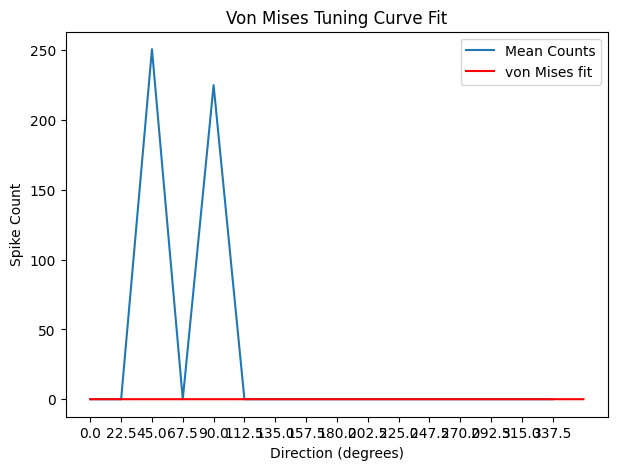

array([-4.49999994e+00,  2.27695242e+00,  1.73663406e+02,  4.05937255e-08])

In [63]:
# ---------------------------------------------------------
# plot tuning curve and fit for different neurons (0.5 pts)
# ---------------------------------------------------------

dirs, counts = get_data(spikes, 31)
# add plot
tuningCurve(dirs, counts)

[53.72727272727273, 89.18181818181819, 61.36363636363637, 22.181818181818183, 20.636363636363637, 33.63636363636363, 26.454545454545453, 29.90909090909091, 33.72727272727273, 42.45454545454545, 64.63636363636364, 61.90909090909091, 46.81818181818182, 41.36363636363637, 33.54545454545455, 39.81818181818182]


C:\Users\nekur\AppData\Local\Temp\ipykernel_10460\3630631426.py:25: RuntimeWarning: overflow encountered in exp
  f = np.exp(


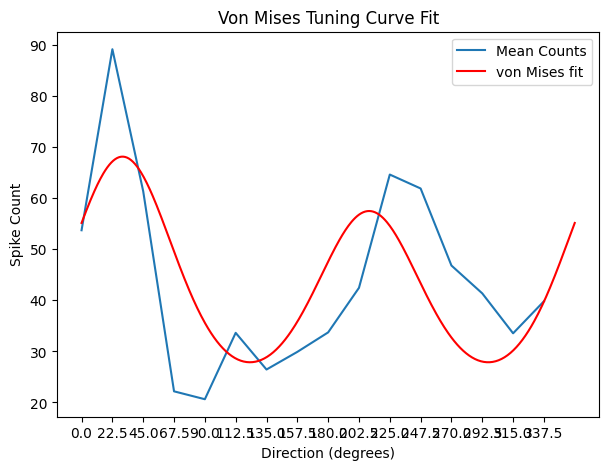

In [64]:
dirs, counts = get_data(spikes, 31)

dist_directs = np.arange(0, 360, 22.5)
mean_directs = []
for d in dist_directs:
    d_idx = np.where(dirs == d)[0]
    if len(d_idx) > 0:
        mean = np.mean(counts[d_idx])
        mean_directs.append(mean)
    else:
        mean_directs.append(0)

print(mean_directs)

initial_guess = [
    1,
    1,
    np.mean(dist_directs),
    np.min(counts),
]  # Initial guess for α, κ, ν, ϕ
p, _ = opt.curve_fit(
    f=vonMises, xdata=dist_directs, ydata=mean_directs, p0=initial_guess
)

# Plot
fig, ax = plt.subplots(figsize=(7, 5))

sns.lineplot(x=dist_directs, y=mean_directs, ax=ax, label="Mean Counts")

fitted_curve = vonMises(np.linspace(0, 360, 500), *p)
ax.plot(np.linspace(0, 360, 500), fitted_curve, label="von Mises fit", color="red")

ax.set_xlabel("Direction (degrees)")
ax.set_xticks(np.arange(0, 360, 22.5))
ax.set_ylabel("Spike Count")
ax.set_title("Von Mises Tuning Curve Fit")
ax.legend()
plt.show()

In [65]:
dirs, counts = get_data(spikes, 29)
# add plot

In [24]:
dirs, counts = get_data(spikes, 36)
# add plot

In [25]:
dirs, counts = get_data(spikes, 37)
# add plot

In [26]:
dirs, counts = get_data(spikes, 32)
# add plot

## Task 4: Permutation test for direction tuning

Implement a permutation test to quantitatively assess whether a neuron is direction/orientation selective. To do so, project the vector of average spike counts, $m_k=\frac{1}{N}\sum_j x_{jk}$ on a complex exponential with two cycles, $v_k = \exp(\psi i \theta_k)$, where $\theta_k$ is the $k$-th direction of motion in radians and $\psi \in 1,2$ is the fourier component to test (1: direction, 2: orientation). Denote the projection by $q=m^Tv$. The magnitude $|q|$ tells you how much power there is in the $\psi$-th fourier component. 

Estimate the distribution of |q| under the null hypothesis that the neuron fires randomly across directions by running 1000 iterations where you repeat the same calculation as above but on a random permutation of the trials (that is, randomly shuffle the entries in the spike count matrix x). The fraction of iterations for which you obtain a value more extreme than what you observed in the data is your p-value. Implement this procedure in the function ```testTuning()```. 

Illustrate the test procedure for one of the cells from above. Plot the sampling distribution of |q| and indicate the value observed in the real data in your plot. 

How many cells are tuned at p < 0.01?

*Grading: 3 pts*


In [27]:
def testTuning(
    counts: np.ndarray,
    dirs: np.ndarray,
    psi: int = 1,
    niters: int = 1000,
    show: bool = False,
    random_seed: int = 2046,
) -> Tuple[float, float, np.ndarray]:
    """Plot the data if show is True, otherwise just return the fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    psi: int
        fourier component to test (1 = direction, 2 = orientation)

    niters: int
        Number of iterations / permutation

    show: bool
        Plot or not.

    random_seed: int
        Random seed for reproducibility.

    Returns
    -------
    p: float
        p-value
    q: float
        magnitude of second Fourier component

    qdistr: np.array
        sampling distribution of |q| under the null hypothesis

    """

    # insert your code here

    # -------------------------------
    # calculate m, nu and q (0.5 pts)
    # -------------------------------

    # -------------------------------------------------------------------------
    # Estimate the distribution of q under the H0 and obtain the p value (1 pt)
    # -------------------------------------------------------------------------
    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)

    if show == True:
        # -------------------------------
        # plot the test results (0.5 pts)
        # -------------------------------
        fig, ax = plt.subplots(figsize=(7, 4))
        # you can use sns.histplot for the histogram
    else:
        return p, q, qdistr

Show null distribution for the example cell:

In [28]:
# ------------------------------------------------------------
# Plot null distributions for example cells 28 & 29. (0.5 pts)
# ------------------------------------------------------------

dirs, counts = get_data(spikes, 28)
# add plot

In [29]:
dirs, counts = get_data(spikes, 29)
# add plot

Test all cells for orientation and direction tuning

In [30]:
# -------------------------------------------------------
# Test cells for orientation / direction tuning (0.5 pts)
# -------------------------------------------------------

# collect p values for orientation / direction selectivity

Number of direction tuned neurons:

In [31]:
# count cells with p < 0.01 (which ones are they?)

Number of orientation tuned neurons:

In [32]:
# count cells with p < 0.01 (which ones are they?)